# Zoom Chat Engagement Analysis

Analysing the contribution of each student to the Zoom chat by compared number of words typed per student and displaying this using graphs and tables. This could be a particularly helpful feature if teachers are trying to encourage students to engage in Zoom chat activities, but can also act as a tool to support assessment of class contributions.

In [1]:
chat_path = input("Please enter the path to the Zoom chat .txt file:   ")
#../ZoomDemo/meeting_saved_chat.txt

Please enter the path to the Zoom chat .txt file:   ../ZoomDemo/meeting_saved_chat.txt


In [2]:
with open(chat_path, 'rt') as fd:
        contents = fd.readlines()
        
# Dictionary to story texts per person and total words per person
texts_person = {}
words_per_person = {}

# Tuple unpacking for file_name, contents
for line in contents:
    line_no_time = line.split('\t')[1]
    person, text = line_no_time.split(':',1)
    person = " ".join(person.split()[1:])
    if person in texts_person:
        texts_person[person].append(line)
        words_per_person[person] += len(text)
    else:
        texts_person[person] = [line]
        words_per_person[person] = len(text.split())

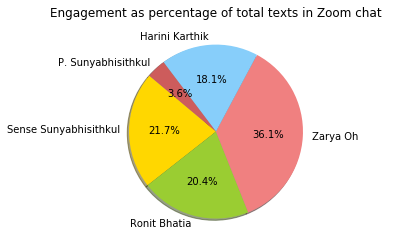

In [4]:
import matplotlib.pyplot as plt

# Plotting a pie chart in term of engagement by text
plt.axis("equal")
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','indianred']
plt.pie([float(v) for v in words_per_person.values()], labels=[k for k in words_per_person.keys()],autopct='%1.1f%%', colors=colors, shadow=True,  startangle=140)
plt.title('Engagement as percentage of total texts in Zoom chat')
plt.savefig('GraphReports/chat_piechart.png', dpi=300, bbox_inches = 'tight')
plt.show()

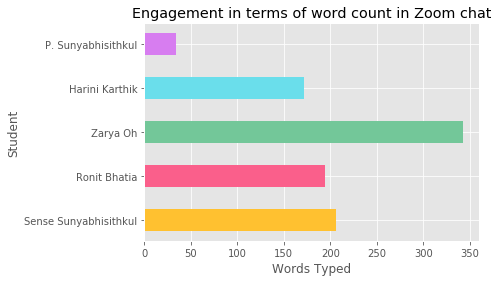

In [5]:
colors = ["#ffc130","#fa5f8b","#73c799","#6adeeb","#d77df0"]
plt.style.use('ggplot')
plt.barh(width=[float(v) for v in words_per_person.values()], y=[k for k in words_per_person.keys()], color=colors, height =0.5)
plt.ylabel("Student")
plt.xlabel("Words Typed")
plt.title('Engagement in terms of word count in Zoom chat')
plt.savefig('GraphReports/chat_barchart.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [6]:
# Find max length of lines of text per person (to avoid error during csv conversion)
texts_list = list(texts_person.values())
max_length = 0
for person in texts_list:
    max_length = max(max_length,len(person))
    
# Producing table as a summary report
import pandas as pd

output = pd.DataFrame()
for name in words_per_person.keys():
    contents = []
    word_num = words_per_person[name]
    if word_num == 1:
        contents.append(str(words_per_person[name])+" word typed") 
    else:
        contents.append(str(words_per_person[name])+" words typed") 
        
    contents.append("Zoom chat contributions:")
    for line in texts_person[name]:
        contents.append(line)
        
    # Add empty lines to shorter columns
    empty_lines = max_length - len(texts_person[name])
    for line in range(empty_lines):
        contents.append("")
        
    output[name] = contents

In [7]:
output

,Sense Sunyabhisithkul,Ronit Bhatia,Zarya Oh,Harini Karthik,P. Sunyabhisithkul
0,206 words typed,194 words typed,343 words typed,172 words typed,34 words typed
1,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:
2,"19:35:51\t From Sense Sunyabhisithkul : Hi, my...","19:39:02\t From Ronit Bhatia : Hi, my name is ...",19:39:12\t From Zarya Oh : hi I’m zarya!\n,19:39:25\t From Harini Karthik : Hi I am Harin...,19:44:05\t From P. Sunyabhisithkul : I was bor...
3,19:38:14\t From Sense Sunyabhisithkul : Also w...,19:39:40\t From Ronit Bhatia : Businesses goin...,19:39:21\t From Zarya Oh : a lot of small busi...,19:40:24\t From Harini Karthik : I am concerne...,19:45:50\t From P. Sunyabhisithkul : cook food...
4,19:41:10\t From Sense Sunyabhisithkul : Will y...,19:41:51\t From Ronit Bhatia : yes - mixture o...,19:41:50\t From Zarya Oh : yup I’ll still be c...,19:41:30\t From Harini Karthik : yes part time...,
5,19:43:38\t From Sense Sunyabhisithkul : Where ...,19:44:12\t From Ronit Bhatia : Born in London ...,19:43:56\t From Zarya Oh : I was born in Singa...,19:43:58\t From Harini Karthik : I was born in...,
6,19:43:51\t From Sense Sunyabhisithkul : And wh...,19:46:00\t From Ronit Bhatia : To be an entrep...,19:46:22\t From Zarya Oh : my biggest aspirati...,19:44:23\t From Harini Karthik : I want to bec...,


# Zoom Conversation (Speech) Engagement Analysis

Analysing the contribution of each student to the Zoom conversion by compared number of words spoken per student and displaying this using graphs and tables. Again, this can be used as a tool for teachers to assess student engagement during Zoom classes. 

***DISCLAIMER:*** This feature is meant to run real-time (see real time script and demo separately) as it is easy for Zoom distinguish audio from different users, whereas we are hard-coding the classification of each line of speech for demonstration purposes only. Also, inaccuracies in Google API Speech Recognition means that records are estimations NOT actual number of words spoken.

In [9]:
import speech_recognition as sr
import pyaudio
import os 
from pydub import AudioSegment
from pydub.silence import split_on_silence
import wave
import contextlib

# a function that splits the audio file into chunks
# and applies speech recognition
def get_large_audio_transcription(path):
    """
    Splitting the large audio file into chunks
    and apply speech recognition on each of these chunks
    """
    r = sr.Recognizer()
    # open the audio file using pydub
    sound = AudioSegment.from_wav(path)  
    # split audio sound where silence is 700 miliseconds or more and get chunks
    chunks = split_on_silence(sound,
        # experiment with this value for your target audio file
        min_silence_len = 500,
        # adjust this per requirement
        silence_thresh = sound.dBFS-14,
        # keep the silence for 1 second, adjustable as well
        keep_silence=500,
    )
    folder_name = "audio-chunks"
    # create a directory to store the audio chunks
    if not os.path.isdir(folder_name):
        os.mkdir(folder_name)
    whole_text = []
    current_time = 0
    # process each chunk 
    for i, audio_chunk in enumerate(chunks, start=1):
        # export audio chunk and save it in
        # the `folder_name` directory.
        chunk_filename = os.path.join(folder_name, f"chunk{i}.wav")
        audio_chunk.export(chunk_filename, format="wav")
        # recognize the chunk
        with contextlib.closing(wave.open(chunk_filename,'r')) as f:
            frames = f.getnframes()
            rate = f.getframerate()
            duration = frames / float(rate)
            print(f"Time: {current_time}")
            current_time += duration
        with sr.AudioFile(chunk_filename) as source:
            audio_listened = r.record(source)
            # try converting it to text
            try:
                text = r.recognize_google(audio_listened)
            except sr.UnknownValueError as e:
                print("Error:", str(e))
            else:
                text = f"{text.capitalize()}. "
                print(chunk_filename, ":", text)
                whole_text.append((round(current_time,2),text))
    # return the text for all chunks detected
    return whole_text

/anaconda3/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [10]:
audio_path = input("Please enter the path to a .wav audio file of Zoom recording: ")
#../ZoomDemo/ZoomDemoAudio.wav
transcript = get_large_audio_transcription(audio_path)

from IPython.display import clear_output
clear_output()

In [11]:
# Tuple unpacking on transcript as time added for debugging purposes
lines = [text for _,text in transcript]

In [12]:
# Hard-coding classification of speaker for each line of transcript (only for demo purposes)
people = list(words_per_person.keys())
# Encode each line by index of person speaking in list above
person_line_keys = [2,0,0,0,0,0,4,0,0,2,0,0,2,3,0,0,2,0,1,2,2,2,1,0,0,1,0,0,3,2,2,2,3,0,2,3,0,4,0,4,4,4,0,2,0,2,2,2,0,0,0,2,2,0,2,2,2,2,0,0,2,0,0,0,0,3,0,0,2,0,0,2,0,2,2,0,0,3,2,0,0,0,2,0,0,0,0,0]

# Create empty dict to track words spoken by each person
words_spoken_per_person = {}
for i, index in enumerate(person_line_keys):
    person = people[index]
    num_words = len(lines[i])
    if person in words_spoken_per_person.keys():
        words_spoken_per_person[person] += num_words
    else:
        words_spoken_per_person[person] = num_words

In [13]:
words_spoken_per_person

{'Zarya Oh': 642,
 'Sense Sunyabhisithkul': 1635,
 'P. Sunyabhisithkul': 135,
 'Harini Karthik': 125,
 'Ronit Bhatia': 59}

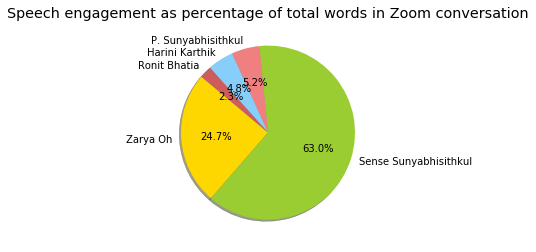

In [14]:
# Plotting a pie chart in term of engagement by speech
plt.axis("equal")
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','indianred']
plt.pie([float(v) for v in words_spoken_per_person.values()], labels=[k for k in words_spoken_per_person.keys()],autopct='%1.1f%%', colors=colors, shadow=True,  startangle=140)
plt.title('Speech engagement as percentage of total words in Zoom conversation')
plt.savefig('GraphReports/speech_piechart.png', dpi=300, bbox_inches = 'tight')
plt.show()

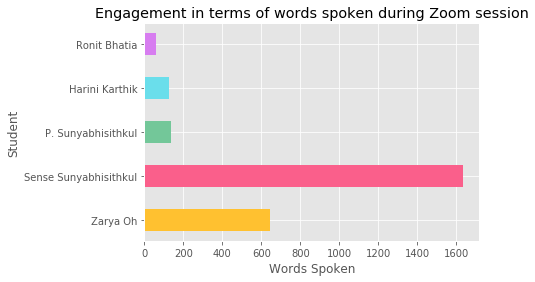

In [15]:
colors = ["#ffc130","#fa5f8b","#73c799","#6adeeb","#d77df0"]
plt.style.use('ggplot')
plt.barh(width=[float(v) for v in words_spoken_per_person.values()], y=[k for k in words_spoken_per_person.keys()], color=colors, height =0.5)
plt.ylabel("Student")
plt.xlabel("Words Spoken")
plt.title('Engagement in terms of words spoken during Zoom session')
plt.savefig('GraphReports/speech_barchart.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [16]:
spoken_summary = [(person,words_spoken_per_person[person]) for person in words_spoken_per_person.keys()]
# Sort by words spoken
spoken_summary.sort(key=lambda x:x[1])
spoken_summary = spoken_summary[::-1]

# Replace old csv with one that includes words spoken per person
output = pd.DataFrame()
for name,spoken_words in spoken_summary:
    contents = []
    word_num = words_per_person[name]
    
    if word_num == 1:
        contents.append(str(spoken_words)+" word spoken") 
    else:
        contents.append(str(spoken_words)+" words spoken") 
        
    if word_num == 1:
        contents.append(str(words_per_person[name])+" word typed") 
    else:
        contents.append(str(words_per_person[name])+" words typed") 
        
    contents.append("Zoom chat contributions:")
    for line in texts_person[name]:
        contents.append(line)
        
    # Add empty lines to shorter columns
    empty_lines = max_length - len(texts_person[name])
    for line in range(empty_lines):
        contents.append("")
        
    output[name] = contents

# Output as CSV file
output.to_csv("GraphReports/chatEngagementSummary.csv", index=False)

In [17]:
output

,Sense Sunyabhisithkul,Zarya Oh,P. Sunyabhisithkul,Harini Karthik,Ronit Bhatia
0,1635 words spoken,642 words spoken,135 words spoken,125 words spoken,59 words spoken
1,206 words typed,343 words typed,34 words typed,172 words typed,194 words typed
2,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:,Zoom chat contributions:
3,"19:35:51\t From Sense Sunyabhisithkul : Hi, my...",19:39:12\t From Zarya Oh : hi I’m zarya!\n,19:44:05\t From P. Sunyabhisithkul : I was bor...,19:39:25\t From Harini Karthik : Hi I am Harin...,"19:39:02\t From Ronit Bhatia : Hi, my name is ..."
4,19:38:14\t From Sense Sunyabhisithkul : Also w...,19:39:21\t From Zarya Oh : a lot of small busi...,19:45:50\t From P. Sunyabhisithkul : cook food...,19:40:24\t From Harini Karthik : I am concerne...,19:39:40\t From Ronit Bhatia : Businesses goin...
5,19:41:10\t From Sense Sunyabhisithkul : Will y...,19:41:50\t From Zarya Oh : yup I’ll still be c...,,19:41:30\t From Harini Karthik : yes part time...,19:41:51\t From Ronit Bhatia : yes - mixture o...
6,19:43:38\t From Sense Sunyabhisithkul : Where ...,19:43:56\t From Zarya Oh : I was born in Singa...,,19:43:58\t From Harini Karthik : I was born in...,19:44:12\t From Ronit Bhatia : Born in London ...
7,19:43:51\t From Sense Sunyabhisithkul : And wh...,19:46:22\t From Zarya Oh : my biggest aspirati...,,19:44:23\t From Harini Karthik : I want to bec...,19:46:00\t From Ronit Bhatia : To be an entrep...
